# Assignment 1 - Inpainting

Name: Thomas Buchegger<br>
Matriculation number: 

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
from scipy import sparse

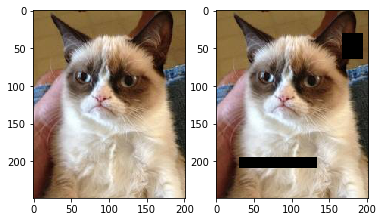

In [2]:
im = array(Image.open('grumpycat.jpeg')) / 256

# mask
h, w, _ = im.shape
omega = ones((h, w))
omega[195:209, 31:134] = 0
omega[31:65, 166:194] = 0

# create input image
omega3 = expand_dims(omega, 2)
g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(g)

## (a) Gradient Descent

In [36]:
def GetD1(uc, gc, omega):
    result = (uc-gc) * omega * 2
    return result

In [12]:
def GetD2(uc, lmbda):

     li, lj = uc.shape
    
     res = zeros((li, lj))

     xf1 = [[0,-1,0],
                 [-1,4,-1],
                 [0,-1,0]] 
    
     res = signal.convolve2d(uc,xf1,'same')
    
     return res*2*lmbda

#     filterX = [1,- 1]
#     filterY = [1,- 1]

#     dx = signal.convolve2d(uc(: ,[1:]),filterX, 'valid');
#     dy=signal.convolve2d(uc(concat([arange(1,end()),end()]),arange()),filterY,'valid')
#     dxy=signal.convolve2d(uc(arange(),concat([arange(1,end()),end()])),- filterX,'valid') + signal.convolve2d(uc(concat([arange(1,end()),end()]),arange()),- filterY,'valid')

    
#     tv=sqrt(dx ** 2 + dy ** 2 + smallValue)
#     a2=zeros(size(dy))
#     a3=zeros(size(dx))

#     for i in arange(2,size(uc,1) - 1).reshape(-1):
#         for j in arange(2,size(A,2) - 1).reshape(-1):
#             a2[i,j]=dy(i - 1,j) / tv(i - 1,j)
#             a3[i,j]=dx(i,j - 1) / tv(i,j - 1)
    
#     a1=dxy / tv
#     result=multiply((a1 + a2 + a3),lambda_)
    
#     return result

In [43]:
def GD(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    
    u = g
    EPS = 0.07
    
    energy = zeros(1000)
    
    # separete colors
    red = u[:, :, 0]
    green = u[:, :, 1]
    blue = u[:, :, 2]
    
    # inverse of the mask
    omegai = 1-omega;
    
    # initial guess
    uRed = red;
    uGreen = green;
    uBlue = blue;    
    
    for i in range(1000):
        
        # calculate gradient for each color channel
        rD1 = GetD1(uRed, red, omega)
        gD1 = GetD1(uGreen, green, omega)
        bD1 = GetD1(uBlue, blue, omega)
        
        rD2 = GetD2(uRed, lmbda)
        gD2 = GetD2(uGreen, lmbda)
        bD2 = GetD2(uBlue, lmbda)
        
        rGrad = rD1 + rD2
        gGrad = gD1 + gD2
        bGrad = bD1 + bD2
        
        # update
        uRed = uRed - rGrad * EPS * omegai
        uGreen = uGreen - gGrad * EPS * omegai
        uBlue = uBlue - bGrad * EPS * omegai
        
        # calculate energy
        energy[i] = linalg.norm((rGrad))
        energy[i] += linalg.norm((gGrad))
        energy[i] += linalg.norm((bGrad))
        
        # show 5 images during the process
        if i ==1:         
            plt.subplot(3, 2, 1)    
            u[:, :,0] = uRed;
            u[:, :,1] = uGreen;
            u[:, :,2] = uBlue;
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1th iteration')
            
        #display 250th iteration
        if i == 250:
            plt.subplot(3, 2, 2)    
            u[:, :,0] = uRed;
            u[:, :,1] = uGreen;
            u[:, :,2] = uBlue;
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('250th iteration')
            
        #display 500 iteration
        if i == 500:
            plt.subplot(3, 2, 3)    
            u[:, :,0] = uRed;
            u[:, :,1] = uGreen;
            u[:, :,2] = uBlue;
        
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('500th iteration') 
            
        #display 750 iteration
        if i == 750:
            plt.subplot(3, 2, 4)    
            u[:, :,0] = uRed;
            u[:, :,1] = uGreen;
            u[:, :,2] = uBlue;
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('750th iteration') 
        #display 1000 iteration
        if i == 1000:
            plt.subplot(3, 2, 5)    
            u[:, :,0] = uRed;
            u[:, :,1] = uGreen;
            u[:, :,2] = uBlue;
            
            plt.imshow(u, interpolation='nearest', aspect='equal')
            plt.title('1000th iteration') 
            
    # concatenate the image
    u[:, :, 0] = uRed
    u[:, :, 1] = uGreen
    u[:, :, 2] = uBlue
    
    fig2 = plt.figure()
    plt.plot(energy)
    plt.title('energy curve')
    fig2.savefig('energyCurve.jpg')
    
    return u

Text(0.5,1,'reconstructed')

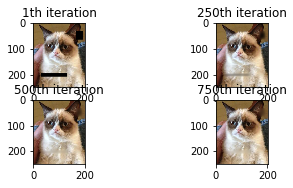

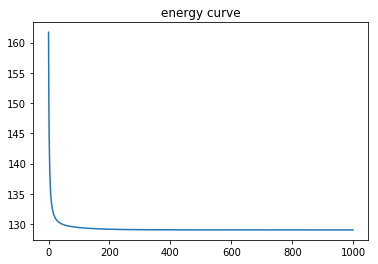

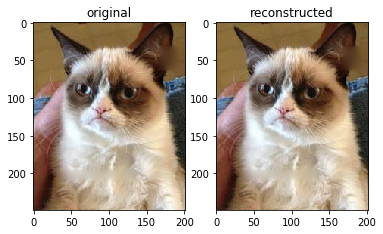

In [54]:
lmbda = 1  # change

uG = GD(g, omega, lmbda)

g = im * omega3

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')

## (b) Linearization + Gauss-Seidel

In [62]:
def Hessian_matrix(u):
    # let 'u' be the known image
    m, n, *_ = u.shape
    
    # define the coordinates of a neighborhood around each pixel 
    # (center, north, south, west, east, north-west, north-east, south-west, south-east)
    # there are 9 possible neighbors
    rows = zeros((9, m * n))
    cols = zeros((9, m * n))
    vals = zeros((9, m * n))

    for i in range(n):
        for j in range(m):
            # center pixel (i, j)
            rows[0, i * m + j] = i * m + j
            cols[0, i * m + j] = i * m + j
            if u[j,i] == 0:
                vals[0, i * m + j] = 4  # here change the value (could depend on 'u')
            else:
                vals[0, i * m + j] = 1
            
            # northern pixel (i, j - 1)
            rows[1, i * m + j] = i * m + j
            cols[1, i * m + j] = i * m + max(j - 1, 0)
            if u[j,i]==0:
                vals[1, i * m + j] = -1  # here change the value (could depend on 'u')
            else :
                vals[1, i * m + j] = 0
            
            # southern pixel (i, j + 1)
            rows[2, i * m + j] = i * m + j
            cols[2, i * m + j] = i * m + min(j + 1, m - 1)
            if u[j,i]==0:
                vals[2, i * m + j] = -1  # here change the value (could depend on 'u')
            else :
                vals[2, i * m + j] = 0
            
            # western pixel  (i - 1, j)
            rows[3, i * m + j] = i * m + j
            cols[3, i * m + j] = max(i - 1, 0) * m + j
            if u[j,i]==0:
                vals[3, i * m + j] = -1  # here change the value (could depend on 'u')
            else :
                vals[3, i * m + j] = 0
            
            # eastern pixel  (i + 1, j)
            rows[4, i * m + j] = i * m + j
            cols[4, i * m + j] = min(i + 1, n - 1) * m + j
            if u[j,i]==0:
                vals[4, i * m + j] = -1  # here change the value (could depend on 'u')
            else :
                vals[4, i * m + j] = 0  
            
            # north-western pixel (i - 1, j - 1)
            rows[5, i * m + j] = i * m + j
            cols[5, i * m + j] = max(i - 1, 0) * m + max(j - 1, 0)
            vals[5, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # north-eastern pixel (i + 1, j - 1)
            rows[6, i * m + j] = i * m + j
            cols[6, i * m + j] = min(i + 1, n - 1) * m + max(j - 1, 0)
            vals[6, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-western pixel (i - 1, j + 1)
            rows[7, i * m + j] = i * m + j
            cols[7, i * m + j] = max(i - 1, 0) * m + min(j + 1, m - 1)
            vals[7, i * m + j] = 0  # here change the value (could depend on 'u')
            
            # south-eastern pixel  (i + 1, j + 1)
            rows[8, i * m + j] = i * m + j
            cols[8, i * m + j] = min(i + 1, n - 1) * m + min(j + 1, m - 1)
            vals[8, i * m + j] = 0  # here change the value (could depend on 'u')

    # generate a sparse matrix
    rows = rows.reshape(-1)
    cols = cols.reshape(-1)
    vals = vals.reshape(-1)
    A = sparse.csr_matrix((vals, (rows, cols)), shape=(n * m, n * m))
    return A

In [75]:
def LGS(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    
    """
    
    u = g
    
    # separete colors
    red = u[:, :, 0]
    green = u[:, :, 1]
    blue = u[:, :, 2]
    
    # inverse of the mask
    omegai = 1-omega;
    
    # initial guess
    uRed = red;
    uGreen = green;
    uBlue = blue;    
    
    for i in range(200):
        
        print(i)
        
        # calculate gradient for each color channel
        rD1 = GetD1(red, red, omega)
        gD1 = GetD1(green, green, omega)
        bD1 = GetD1(blue, blue, omega)
        
        rD2 = GetD2(red, lmbda)
        gD2 = GetD2(blue, lmbda)
        bD2 = GetD2(green, lmbda)
        
        rGrad = (rD1 + rD2) * omegai
        gGrad = (gD1 + gD2) * omegai
        bGrad = (bD1 + gD2) * omegai
        
        # calc A
        Ar = Hessian_matrix(red)
        Ag = Hessian_matrix(green)
        Ab = Hessian_matrix(blue)
        
        # reshape u and gradient of energy of u
        uRed = reshape(uRed, (size(uRed), 1))
        uGreen = reshape(uGreen, (size(uGreen), 1))
        uBlue = reshape(uBlue, (size(uBlue), 1))
        
        rGrad = reshape(rGrad, (size(rGrad), 1))
        gGrad = reshape(gGrad, (size(gGrad), 1))
        bGrad = reshape(bGrad, (size(bGrad), 1))
        
        # calc b
        br = Ar * uRed - rGrad
        bg = Ag * uGreen - gGrad
        bb = Ab * uBlue - bGrad
        
        # Decompose A into L + D + U
        Dr = sparse.dia_matrix(Ar)
        Dg = sparse.dia_matrix(Ag)
        Db = sparse.dia_matrix(Ab)        
        
        # get lower matrix
        Lr = sparse.tril(Ar, 0)
        Lg = sparse.tril(Ag, 0)
        Lb = sparse.tril(Ab, 0)
        
        # get upper matrix
        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)
        
        
        # Update:
        uRed =  sparse.linalg.spsolve(Lr, (br - Ur * uRed))
        uGreen = sparse.linalg.spsolve(Lg, (bg - Ug * uGreen))
        uGreen = sparse.linalg.spsolve(Lb, (bb - Ub * uBlue))
        
        # Backshape image
        uRed = reshape(uRed,(shape(uRed)))
        uGreen = reshape(uGreen,(shape(uGreen)))
        uBlue = reshape(uBlue,(shape(uBlue)))
        
    # concatinate image again:
    u[:, : ,0] = red
    u[:, :, 1] = green
    u[:, :, 2] = blue

    return u


In [ ]:
lmbda = 0.07  # change

g = im * omega3

uG = LGS(g, omega, lmbda)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')

0


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


## (c) Linearization + SOR

In [45]:
def LSOR(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter

    :returns u: inpainted image of size (M, N, 3)
    """
    u = g
    
    # separate color channels:
    red = u[:, :, 0]
    green = u[:, :, 1]
    blue = u[:, :, 2]
    
    # set initial guess:
    uRed = red
    uGreen = green
    uBlue = blue

    # Set value of w: (w>1 to speed up converging process) (0 < w < 2)
    w=1

    for i in arange(1,1000).reshape(-1):
        # Calculate gradient for each color channel:
        rD1 = GetD1(uRed,red,omega)
        gD1 = GetD1(uGreen,green,omega)
        bD1 = GetD1(uBlue,blue,omega)

        rD2 = GetD2(uRed,lmbda)
        gD2 = GetD2(uGreen,lmbda)
        bD2 = GetD2(uBlue,lmbda)

        rGrad = rD1 + rD2
        gGrad = gD1 + gD2
        bGrad = bD1 + bD2

        Ar = Hessian_matrix(uRed)
        Ag = Hessian_matrix(uGreen)
        Ab = Hessian_matrix(uBlue)

        uRed = reshape(uRed,(size(uRed),1))
        uGreen = reshape(uGreen,(size(uGreen),1))
        uBlue = reshape(uBlue,(size(uBlue),1))
    
        rGrad = reshape(rGrad,(size(rGrad),1))
        gGrad = reshape(gGrad,(size(gGrad),1))
        bGrad = reshape(bGrad,(size(bGrad),1))
    
        br = Ar * uRed - rGrad
        bg = Ag * uGreen - gGrad
        bb = Ab * uBlue - bGrad

        Dr = sparse.dia_matrix(Ar)
        Dg = sparse.dia_matrix(Ag)
        Db = sparse.dia_matrix(Ab)

        Lr = sparse.tril(Ar,- 1)
        Lg = sparse.tril(Ag,- 1)
        Lb = sparse.tril(Ab,- 1)

        DLr = sparse.tril(Ar,0)
        DLg = sparse.tril(Ag,0)
        DLb = sparse.tril(Ab,0)

        Ur = sparse.triu(Ar,1)
        Ug = sparse.triu(Ag,1)
        Ub = sparse.triu(Ab,1)
        
        uRed = multiply((1 - w),uRed) + linalg.solve(multiply(w,DLr),(br - dot(Ur,uRed)))
        uGreen = multiply((1 - w),uGreen) + linalg.solve(multiply(w,DLg),(bg - dot(Ug,uGreen)))
        uBlue = multiply((1 - w),uBlue) + linalg.solve(multiply(w,DLb),(bb - dot(Ub,uBlue)))
        
        uRed = reshape(uRed,size(g(arange(),arange(),1)))
        uGreen = reshape(uGreen,size(g(arange(),arange(),1)))
        uBlue = reshape(uBlue,size(g(arange(),arange(),1)))

    
    # concatinate image again:
    u[:,:,0] = uRed
    u[:,:,1]=uGreen
    u[:,:,2]=uBlue

    return u
    

In [46]:
lmbda = 1  # change

g = im * omega3

uG = LSOR(g, omega, lmbda)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(g)
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(uG)
plt.title('reconstructed')

MemoryError: 